#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

План работы:
1. Загрузить и проанализировать данные:

   1.1 Проверить на монотонность.
   
   1.2 Провести ресемплирование, т.е. изменение временного ряда по одному часу.
   
   1.3 Посмотреть распределение заказов всего временного ряда.
   
   1.4 Если на графике будет наблюдаться тренд, проверить на тренд и сезонность.
   

2. Создать признаки исходя из сезонности распределения, а также обучить модели и проверить RMSE на входящих данных.

3. Протестировать модели на тестовых данных(10% от общего д-сета), в сравнительном анализе определить лучшую модель.

## Подготовка

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

import time
import warnings
warnings.simplefilter('ignore')

In [5]:
df = pd.read_csv('C:/Users/Денис/Desktop/Проекты/Vremennie_ryadi/taxi.csv')

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Заменим тип данных в datetime с object на datetime64

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Данные изменились, продолжим анализ.

## Анализ

Изменим индекс таблицы и проверим на монотонность.

In [8]:
df.index = df['datetime']
df.index.is_monotonic

True

<font color="brown">⚠️ Комментарий ревьювера     
Верно. Для простоты можно было сразу при загрузке указать:   
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])


Данные расположены с хронологическом порядке. Проведем ресемплирование и посмотрим на график временного ряда.

In [9]:
#т.к. данные изначально распределены в 10-ти минутном интервале, а нам нужно общее количество заказов,
#то после ресемплирования проссумируем данные

df = df.resample('1H').sum()


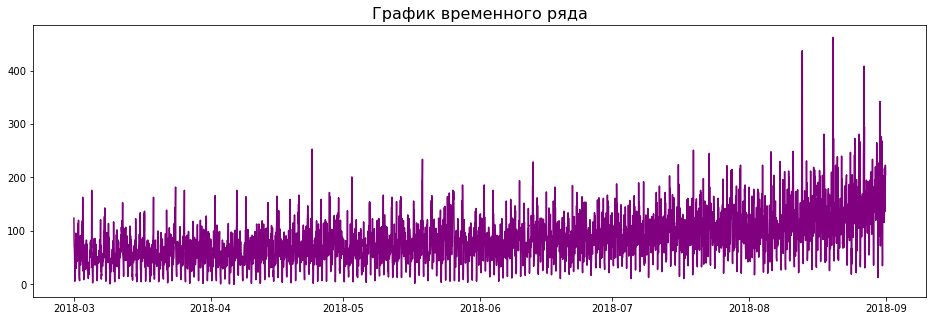

In [10]:
plt.figure(figsize=(16,5))
plt.title('График временного ряда', fontsize=16)
plt.plot(df, color='purple')
plt.show()

По графику прослеживается уход вверх к концу графика, проверим на тренд.

In [11]:
def trend(data, n):
    rolling_mean = data.rolling(n).mean()
    plt.figure(figsize=(16,5))
    plt.title('Скользящее среднее\n Размер окна = {}'.format(n))
    plt.plot(rolling_mean, color='purple')

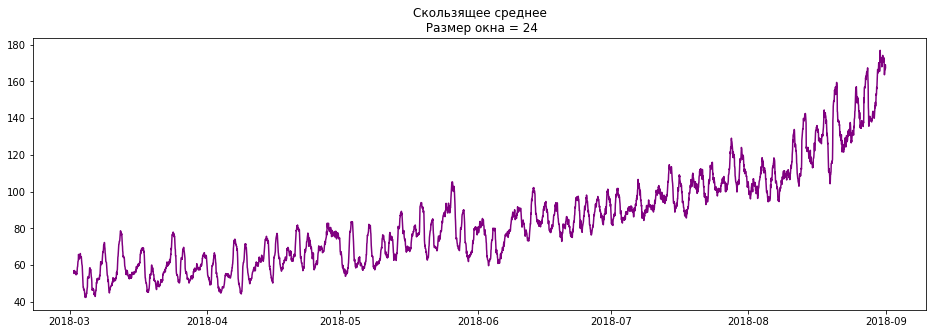

In [12]:
trend(df,24)

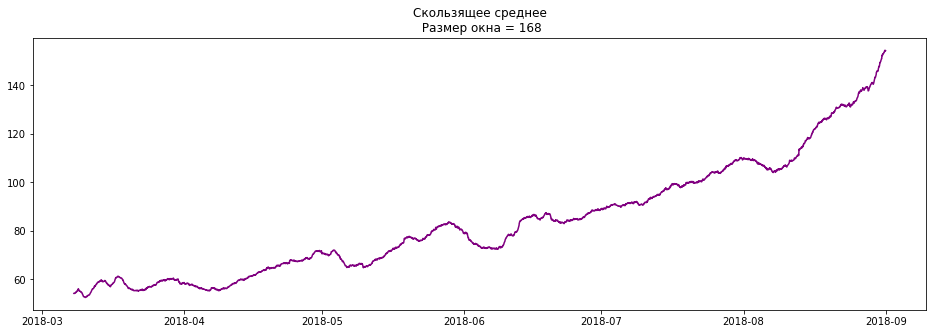

In [13]:
trend(df, 24*7)

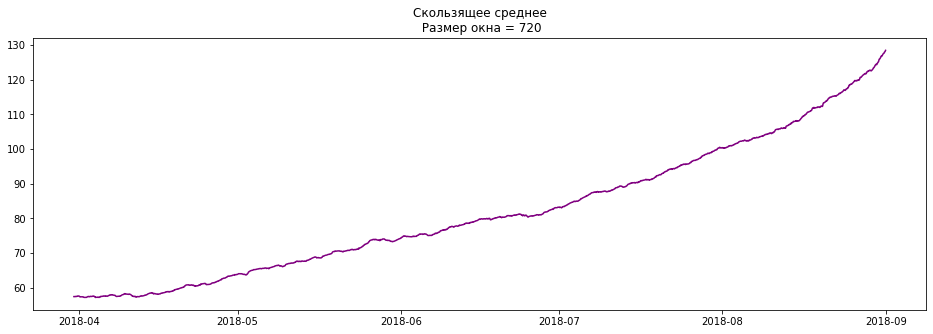

In [14]:
trend(df, 24*30)

На графике явно прослеживается годовой тренд. Также на графиках прослеживаются колебания, которые могут быть дневной или недельной сезонностью. Проверим их.

In [15]:
def seasonal(data, interval_1, interval_2):
    sd = seasonal_decompose(data)
    plt.figure(figsize=(16,5))
    plt.title('Сезонность')
    sd.trend[interval_1 : interval_2].plot(ax=plt.gca(), color='purple')

Проверим на дневную сезонность.

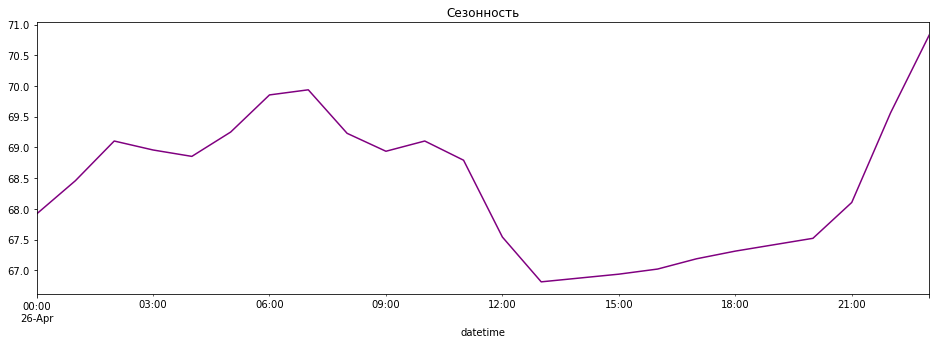

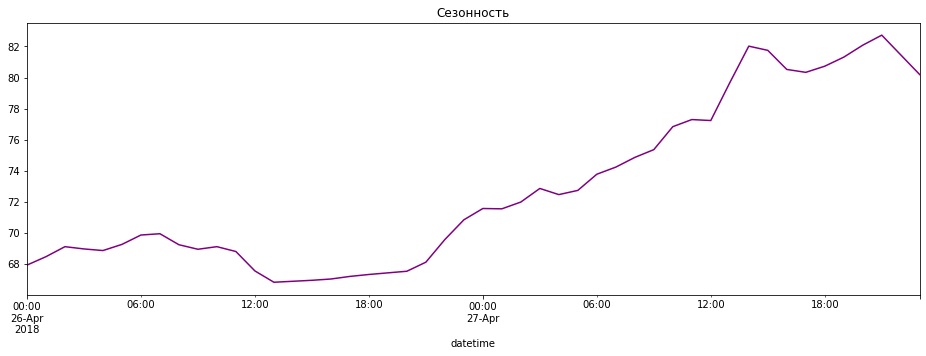

In [16]:
seasonal(df, '2018-04-26', '2018-04-26') 
seasonal(df, '2018-04-26','2018-04-27')

В течение дня наблюдается как повышение временного ряда, так и его пaдение. Наблюдается снижение количества заказов к дневным часам, а также повышение к ночным. 

Проверим на недельную сезонность.

(None, None)

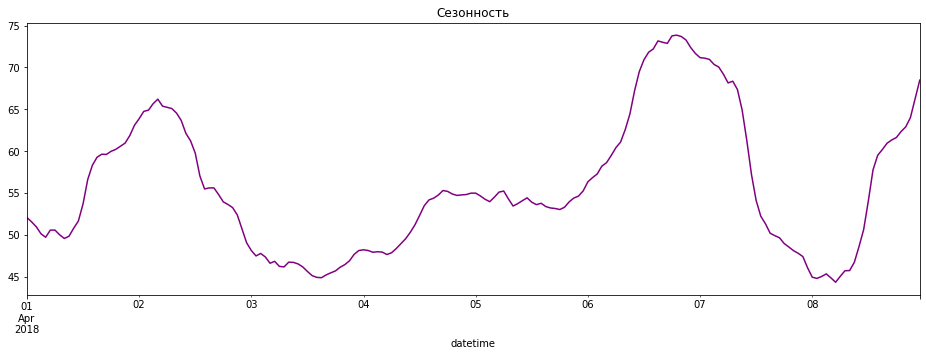

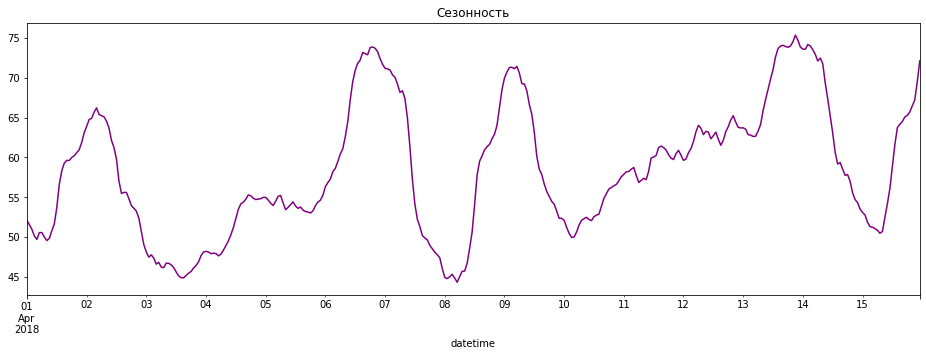

In [14]:
seasonal(df, '2018-04-01', '2018-04-08'), seasonal(df, '2018-04-01','2018-04-15')

Посмотрев в календаре на какой день недели выпадают даты, можно сделать вывод, что на неделе заказы такси тоже имеют сезонность. Наибольшее количество заказов приходиться на вторник и субботу, в то время как в остальные дни график либо ростет, при движении в сторону выходных, лмбо опускается, при движении в сторону будних дней.

Промежуточный вывод:
- Во временном ряде присутствует тренд.
- Наблюдается сезонность в течение дня (в дневные часы заказов меньше)
- Наблюдается сезонность в течение недели (вторник и суббота показывают пик во временном ряду, значит и количество заказов в эти дни больше) 

Соответственно при обучении модели стоит обратить внимание на эти факторы, а значит и создать для них дополнительные признаки:
- день
- месяц
- день недели
- вторник
- суббота
- дневные часы (с 12:00 до 15:00)

## Обучение

In [17]:
#Создадим функцию, с новыми параметрами
def make_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['tuesday'] = data.index.dayofweek.isin([1])
    data['saturday'] = data.index.dayofweek.isin([5])
    data['daytime_hours'] = data.index.hour.isin(range(11,14))
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.dropna()
    
    features = data.drop(['num_orders'], axis = 1)
    target = data['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(features,  target,
                                                                                  shuffle=False, test_size=0.1)
    
    return features, target, data, features_train, features_test, target_train, target_test


In [18]:
features, target, data, features_train, features_test, target_train, target_test = make_features(df, 100, 5)

In [19]:
data.head()

,num_orders,dayofweek,hour,tuesday,saturday,daytime_hours,lag_1,lag_2,lag_3,lag_4,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,False,False,False,51.0,32.0,176.0,86.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,82.6
2018-03-05 05:00:00,16,0,5,False,False,False,34.0,51.0,32.0,176.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,75.8
2018-03-05 06:00:00,3,0,6,False,False,False,16.0,34.0,51.0,32.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,61.8
2018-03-05 07:00:00,14,0,7,False,False,False,3.0,16.0,34.0,51.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,27.2
2018-03-05 08:00:00,31,0,8,False,False,False,14.0,3.0,16.0,34.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,23.6


LinearRegression

In [20]:
%%time
model_Linear = LinearRegression()
model_Linear.fit(features_train, target_train)
model_Linear_predict = model_Linear.predict(features_train)
print('RMSE:', MSE(target_train, model_Linear_predict)**0.5)


RMSE: 22.10271383610074
CPU times: total: 406 ms
Wall time: 439 ms


GradientBoostingRegressor

In [21]:
%%time
model_GBR = GradientBoostingRegressor(random_state=12345)
model_GBR.fit(features_train, target_train)
model_GBR_predict = model_GBR.predict(features_train)
print('RMSE:', MSE(target_train, model_GBR_predict)**0.5)

RMSE: 18.111988655210087
CPU times: total: 6.33 s
Wall time: 6.42 s


XGBoost

In [25]:
%%time
dtrain = xgb.DMatrix(features_train, label=target_train) 
dtest = xgb.DMatrix(features_test, label=target_test)

params = {'max_depth': 10, 'eta':.3}
num_round = 10

model_xgb = xgb.train(params, dtrain, num_round)
model_xgb_predict = model_xgb.predict(dtrain)

print('RMSE:', MSE(target_train, model_xgb_predict)**0.5)

RMSE: 7.5992285547090015
CPU times: total: 3.08 s
Wall time: 853 ms


CatBoost

In [23]:
%%time
params_cat = {'iterations': [100], 'depth': [x for x in range (2,16,2)]}
grid_cat = GridSearchCV(estimator = CatBoostRegressor(random_state = 12345),
                       param_grid = params_cat, cv=2, verbose=False, n_jobs=-1)
#grid_cat.fit(features_train, target_train)
#grid_cat.best_params_

CPU times: total: 0 ns
Wall time: 46 ms


In [24]:
%%time
model_CatBoost = CatBoostRegressor(iterations = 100, depth = 4, verbose = 1000, loss_function='RMSE')
model_CatBoost.fit(features_train,target_train)
model_CatBoost_predict = model_CatBoost.predict(features_train)
print('RMSE:', MSE(target_train, model_CatBoost_predict)**0.5)

Learning rate set to 0.285952
0:	learn: 34.0820815	total: 306ms	remaining: 30.3s
99:	learn: 16.7975125	total: 1.54s	remaining: 0us
RMSE: 16.79751250114635
CPU times: total: 4.56 s
Wall time: 3.11 s


Посмотрим какие результаты показали модели на обучающей выборке:

In [26]:
result = [[22.10, '439 ms'],
          [18.11, '6.42 s'],
          [7.59, '3.08 s'],
          [16.79, '3.11 s']]
index = ['Linear', "GradienBoost", 'XGBoost', 'Catboost']

resultat = pd.DataFrame(data=result, index=index, columns = ['RMSE', 'time'])
resultat

,RMSE,time
Linear,22.10,439 ms
GradienBoost,18.11,6.42 s
XGBoost,7.59,3.08 s
Catboost,16.79,3.11 s


На обучающих данный нам подходит любая модель, т.к. все показали отличный рещультат, протестируем модели.

## Тестирование

In [27]:
%%time
model_Linear_predict_test = model_Linear.predict(features_test)
print('RMSE:', MSE(target_test, model_Linear_predict_test)**0.5)

RMSE: 40.079904038545926
CPU times: total: 31.2 ms
Wall time: 12 ms


In [28]:
%%time
model_GBR_predict_test = model_GBR.predict(features_test)
print('RMSE:', MSE(target_test, model_GBR_predict_test)**0.5)

RMSE: 41.7554257202018
CPU times: total: 15.6 ms
Wall time: 15 ms


In [29]:
%%time
model_xgb_predict_test = model_xgb.predict(dtest)
print('RMSE:', MSE(target_test, model_xgb_predict_test)**0.5)

RMSE: 53.025258562367725
CPU times: total: 0 ns
Wall time: 6 ms


In [30]:
%%time
model_CatBoost_predict_test = model_CatBoost.predict(features_test)
print('RMSE:', MSE(target_test, model_CatBoost_predict_test)**0.5)

RMSE: 39.37945761491493
CPU times: total: 15.6 ms
Wall time: 19 ms


In [31]:
result_test = [40.08, 41.7, 53.0, 39.37]
resultat_test = pd.DataFrame(data=result_test, index=index, columns = ['RMSE'])
resultat_test

,RMSE
Linear,40.08
GradienBoost,41.70
XGBoost,53.00
Catboost,39.37


Результаты на тестах примерно одинаковые у трех моделей, однако все таки чуточку лучше себя покзывает CatBoost

Посмотрим на распределение по графику

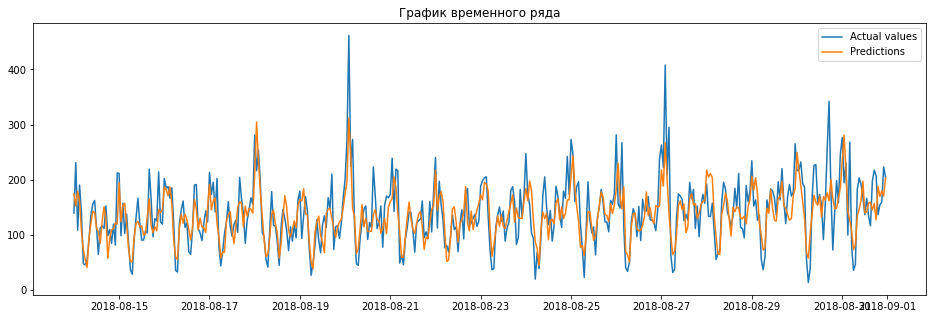

In [32]:
plt.figure(figsize=(16,5))
plt.plot(features_test.index, target_test, label='Actual values')
plt.plot(features_test.index, model_CatBoost_predict_test, label='Predictions')
plt.title('График временного ряда')
plt.legend()
plt.show()

### ВЫВОД:

По ходу работы были заргужены, подготовлены и проанализированы данные сервиса "Четенькое такси". По полученным данным были посторены и обучены различные модели, способные прогнозировать количество заказов такси в различные временные периоды. В итоге после тестирования три модели показали устраивающий нас результат, из которых была выбрана одна с наилучшими предсказаниями. Для данной модели построен график предсказаний в сравнении с реальными результатами.